# Analyse ground truth labeling job dataset

### Set up

importing modules needed and define s3 dataset location

In [2]:
%matplotlib inline
import os
from collections import namedtuple
from collections import defaultdict
from collections import Counter
from datetime import datetime
import itertools
import glob
import json
import random
import time
import imageio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import shutil
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import confusion_matrix
import boto3
import botocore
import sagemaker
from urllib.parse import urlparse

# lebeling job dataset s3 location name
BUCKET = 'number-detector-data-0909'
training_job_prefix = 'train-label-0909'

### Retrieve labeling job status

In [6]:
# Make sure the bucket is in the same region as this notebook.
role = sagemaker.get_execution_role()
region = boto3.session.Session().region_name
s3 = boto3.client('s3')
sagemaker_client = boto3.client('sagemaker')

Once the job has finished, we can analyze the results. Evaluate the following cell and verify the output is 'Completed' before continuing.

In [7]:
training_labeling_jobname = "number-detector-emn-train-labelingjob"
sagemaker_client.describe_labeling_job(LabelingJobName=training_labeling_jobname)['LabelingJobStatus']

'Completed'

## Postprocess the Training output manifest
Now that the job is complete, we will download the output manifest manfiest and postprocess it to create a list of `output_images` with the results. Each entry in the list will be a `BoxedImage` object that contains information about the image and the bounding boxes created by the labeling jobs.

In [9]:
training_dataset_output = boto3.client('sagemaker').describe_labeling_job(LabelingJobName=training_labeling_jobname)[
    'OutputConfig']['S3OutputPath'] + training_labeling_jobname

print(training_dataset_output)

s3://number-detector-data-0909/train-label-0909/number-detector-emn-train-labelingjob


In [10]:
# Load the output manifest's annotations.
training_manifest = 's3://{}/{}/{}/manifests/output/output.manifest'.format(BUCKET, training_job_prefix, training_labeling_jobname)
!aws s3 cp {training_manifest} '0917_gtdata_analyse/training/output.manifest'

with open('0917_gtdata_analyse/training/output.manifest', 'r') as f:
    output = [json.loads(line.strip()) for line in f.readlines()]
    
# # Retrieve the worker annotations.
!aws s3 cp {training_dataset_output + '/annotations/worker-response'} '0917_gtdata_analyse/training/worker-response/' --recursive --quiet

# Find the worker files.
worker_file_names = glob.glob(
    '0917_gtdata_analyse/training/worker-response/**/*.json', recursive=True)
print(output)
print(worker_file_names)

download: s3://number-detector-data-0909/train-label-0909/number-detector-emn-train-labelingjob/manifests/output/output.manifest to gtdata_analyse/training/output.manifest
[{'source-ref': 's3://number-detector-data-0909/train-0909/Clip1Frame00031_1_05_09.jpg', 'number-detector-emn-train-labelingjob': {'image_size': [{'width': 108, 'height': 231, 'depth': 3}], 'annotations': [{'class_id': 1, 'top': 54.599999999999994, 'left': 38.6, 'height': 37, 'width': 14.799999999999997}, {'class_id': 7, 'top': 54.80000000000001, 'left': 52.4, 'height': 36.79999999999998, 'width': 19.199999999999996}]}, 'number-detector-emn-train-labelingjob-metadata': {'objects': [{'confidence': 0.81}, {'confidence': 0.86}], 'class-map': {'1': '1', '7': '7'}, 'type': 'groundtruth/object-detection', 'human-annotated': 'yes', 'creation-date': '2021-09-08T17:38:20.298128', 'job-name': 'labeling-job/number-detector-emn-train-labelingjob'}}, {'source-ref': 's3://number-detector-data-0909/train-0909/Clip1Frame00061_1_05_0

In [25]:
from ground_truth_od import BoundingBox, WorkerBoundingBox, \
    GroundTruthBox, BoxedImage

fids2bbs = defaultdict(list)

# Create data arrays.
confidences = np.zeros(len(output))

# Find the job name the manifest corresponds to.
keys = list(output[0].keys())
metakey = keys[np.where([('-metadata' in k) for k in keys])[0][0]]
# print("output[0]: {}".format(output[0]))
# print("keys: {}".format(keys))
# print("metakey: {}".format(metakey))
jobname = metakey[:-9]
# print("jobname: {}".format(jobname))
output_images = []
consolidated_boxes = []
num_obj_list = []


# Extract the data.
for datum_id, datum in enumerate(output):
    image_size = datum[jobname]['image_size'][0]
    box_annotations = datum[jobname]['annotations']
    uri = datum['source-ref']
    box_confidences = datum[metakey]['objects']
    human = int(datum[metakey]['human-annotated'] == 'yes')

    # Make image object.
    image = BoxedImage(id=datum_id, size=image_size,
                       uri=uri)

    # Create bounding boxes for image.
    boxes = []
    for i, annotation in enumerate(box_annotations):
        box = BoundingBox(image_id=datum_id, boxdata=annotation)
        box.confidence = box_confidences[i]['confidence']
        box.image = image
        box.human = human
        boxes.append(box)
        consolidated_boxes.append(box)
        
        num_obj_list.append("{}".format(annotation["class_id"]))
        
    image.consolidated_boxes = boxes

    # Store if the image is human labeled.
    image.human = human

    # Retrieve ground truth boxes for the image.
    oid_boxes_data = fids2bbs[image.oid_id]
    gt_boxes = []
    for data in oid_boxes_data:
        gt_box = GroundTruthBox(image_id=datum_id, oiddata=data,
                                image=image)
        gt_boxes.append(gt_box)
    image.gt_boxes = gt_boxes

    output_images.append(image)


# Iterate through the json files, creating bounding box objects.
for wfn in worker_file_names:
    image_id = int(wfn.split('/')[-2])
    image = output_images[image_id]
    with open(wfn, "r") as worker_file:
        annotation = json.load(worker_file)
        answers = annotation['answers']
        for answer in answers:
            wid = answer['workerId']
            wboxes_data = \
                answer['answerContent']['boundingBox']['boundingBoxes']
            for boxdata in (wboxes_data or []):
                box = WorkerBoundingBox(image_id=image_id,
                                        worker_id=wid,
                                        boxdata=boxdata)
                box.image = image
                image.worker_boxes.append(box)

# Get the human- and auto-labeled images.
human_labeled = [img for img in output_images if img.human]
auto_labeled = [img for img in output_images if not img.human]

# print(len(human_labeled))
# print(len(auto_labeled))
print(num_obj_list)

['1', '7', '2', '8', '1', '7', '1', '2', '3', '2', '2', '3', '2', '2', '2', '2', '8', '2', '2', '0', '0', '1', '2', '1', '0', '1', '2', '2', '2', '2', '5', '7', '2', '8', '5', '2', '3', '7', '2', '8', '7', '5', '1', '2', '3', '2', '8', '2', '3', '1', '7', '5', '5', '2', '3', '7', '2', '8', '7', '2', '8', '7', '2', '8', '5', '2', '8', '6', '2', '5', '2', '1', '1', '7', '1', '7', '1', '7', '0', '1', '2', '9', '9', '1', '0', '1', '7', '1', '0', '9', '9', '1', '7', '2', '2', '8', '1', '7', '2', '8', '1', '7', '1', '7', '2', '3', '8', '1', '2', '2', '1', '2', '1', '1', '2', '5', '5', '1', '2', '1', '2', '5', '7', '5', '5', '2', '1', '5', '2', '1', '2', '7', '1', '2', '2', '2', '7', '1', '5', '8', '5', '8', '8', '2', '2', '1', '1', '0', '3', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '2', '1', '1', '7', '6', '2', '2', '2', '5', '1', '2', '2', '5', '2', '1', '2', '0', '2', '0', '3', '1', '8', '2', '4', '1', '5', '6', '1', '0', '1', '7', '1', '7', '7', '1', '5', '2', '4', '1', '7', '5',

## Plot data distribution histogram

Plot how many time each digits are labeled

<AxesSubplot:>

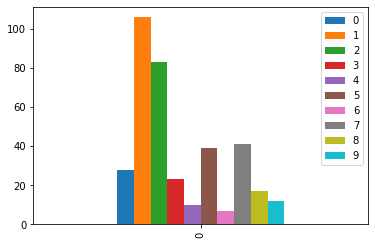

In [31]:
import pandas
from collections import Counter
letter_counts = Counter(num_obj_list)
df = pandas.DataFrame.from_dict(letter_counts, orient='index').transpose()[['0','1','2','3','4','5','6','7','8','9']]
df.plot(kind='bar')

## Plot annotated images
In any data science task, it is crucial to plot and inspect the results to check they make sense. In order to do this, we will 
1. Download the input images that Ground Truth annotated.
2. Separate images annotated by humans from those annoted via the auto-labeling mechanism.
3. Plot images in the human/auto-annotated classes.

We will download the input images to a `LOCAL_IMAGE_DIR` you can choose in the next cell. Note that if this directory already contains images with the same filenames as your Ground Truth input images, we will not re-download the images.

If your dataset is large and you do not wish to download and plot **all** the images, simply set `DATASET_SIZE` to a small number. We will pick a random subset of your data for plotting.

In [31]:
LOCAL_IMG_DIR = '0910-analysis-dataset-training-imgs' # Replace with the name of a local directory to store images.
DATASET_SIZE = len(output_images) # Change this to a reasonable number if your dataset is larger than 10K images.

image_subset = np.random.choice(output_images, DATASET_SIZE, replace=False)

for img in image_subset:
    target_fname = os.path.join(
        LOCAL_IMG_DIR, img.uri.split('/')[-1])
    print(target_fname)
    if not os.path.isfile(target_fname):
        !aws s3 cp {img.uri} {target_fname}

print(len(image_subset))

0910-analysis-dataset-training-imgs/epic_clip4_frame24_4_08_09.jpg
download: s3://number-detector-data-0909/train-0909/epic_clip4_frame24_4_08_09.jpg to 0910-analysis-dataset-training-imgs/epic_clip4_frame24_4_08_09.jpg
0910-analysis-dataset-training-imgs/epic_clip4_frame6_1_08_09.jpg
download: s3://number-detector-data-0909/train-0909/epic_clip4_frame6_1_08_09.jpg to 0910-analysis-dataset-training-imgs/epic_clip4_frame6_1_08_09.jpg
0910-analysis-dataset-training-imgs/epic_clip4_frame60_9_08_09.jpg
download: s3://number-detector-data-0909/train-0909/epic_clip4_frame60_9_08_09.jpg to 0910-analysis-dataset-training-imgs/epic_clip4_frame60_9_08_09.jpg
0910-analysis-dataset-training-imgs/neymar_clip1_frame50_4_08_09.jpg
download: s3://number-detector-data-0909/train-0909/neymar_clip1_frame50_4_08_09.jpg to 0910-analysis-dataset-training-imgs/neymar_clip1_frame50_4_08_09.jpg
0910-analysis-dataset-training-imgs/neymar_clip1_frame390_1_08_09.jpg
download: s3://number-detector-data-0909/train-

0910-analysis-dataset-training-imgs/epic_clip3_frame360_1_08_09.jpg
download: s3://number-detector-data-0909/train-0909/epic_clip3_frame360_1_08_09.jpg to 0910-analysis-dataset-training-imgs/epic_clip3_frame360_1_08_09.jpg
0910-analysis-dataset-training-imgs/clip_3_frame195_1_05_09.jpg
download: s3://number-detector-data-0909/train-0909/clip_3_frame195_1_05_09.jpg to 0910-analysis-dataset-training-imgs/clip_3_frame195_1_05_09.jpg
0910-analysis-dataset-training-imgs/neymar_clip1_frame370_1_08_09.jpg
download: s3://number-detector-data-0909/train-0909/neymar_clip1_frame370_1_08_09.jpg to 0910-analysis-dataset-training-imgs/neymar_clip1_frame370_1_08_09.jpg
0910-analysis-dataset-training-imgs/epic_clip4_frame30_4_08_09.jpg
download: s3://number-detector-data-0909/train-0909/epic_clip4_frame30_4_08_09.jpg to 0910-analysis-dataset-training-imgs/epic_clip4_frame30_4_08_09.jpg
0910-analysis-dataset-training-imgs/epic_clip4_frame36_5_08_09.jpg
download: s3://number-detector-data-0909/train-090

0910-analysis-dataset-training-imgs/epic_clip1_frame54_1_08_09.jpg
download: s3://number-detector-data-0909/train-0909/epic_clip1_frame54_1_08_09.jpg to 0910-analysis-dataset-training-imgs/epic_clip1_frame54_1_08_09.jpg
0910-analysis-dataset-training-imgs/clip4_frame40_1_05_09.jpg
download: s3://number-detector-data-0909/train-0909/clip4_frame40_1_05_09.jpg to 0910-analysis-dataset-training-imgs/clip4_frame40_1_05_09.jpg
0910-analysis-dataset-training-imgs/clip_3_frame65_2_05_09.jpg
download: s3://number-detector-data-0909/train-0909/clip_3_frame65_2_05_09.jpg to 0910-analysis-dataset-training-imgs/clip_3_frame65_2_05_09.jpg
0910-analysis-dataset-training-imgs/epic_clip4_frame24_12_08_09.jpg
download: s3://number-detector-data-0909/train-0909/epic_clip4_frame24_12_08_09.jpg to 0910-analysis-dataset-training-imgs/epic_clip4_frame24_12_08_09.jpg
0910-analysis-dataset-training-imgs/neymar_clip1_frame40_2_08_09.jpg
download: s3://number-detector-data-0909/train-0909/neymar_clip1_frame40_2_

0910-analysis-dataset-training-imgs/epic_clip3_frame252_1_08_09.jpg
download: s3://number-detector-data-0909/train-0909/epic_clip3_frame252_1_08_09.jpg to 0910-analysis-dataset-training-imgs/epic_clip3_frame252_1_08_09.jpg
0910-analysis-dataset-training-imgs/epic_clip4_frame6_4_08_09.jpg
download: s3://number-detector-data-0909/train-0909/epic_clip4_frame6_4_08_09.jpg to 0910-analysis-dataset-training-imgs/epic_clip4_frame6_4_08_09.jpg
0910-analysis-dataset-training-imgs/clip4_frame20_2_05_09.jpg
download: s3://number-detector-data-0909/train-0909/clip4_frame20_2_05_09.jpg to 0910-analysis-dataset-training-imgs/clip4_frame20_2_05_09.jpg
0910-analysis-dataset-training-imgs/clip4_frame40_6_05_09.jpg
download: s3://number-detector-data-0909/train-0909/clip4_frame40_6_05_09.jpg to 0910-analysis-dataset-training-imgs/clip4_frame40_6_05_09.jpg
0910-analysis-dataset-training-imgs/Clip1Frame00271_4_05_09.jpg
download: s3://number-detector-data-0909/train-0909/Clip1Frame00271_4_05_09.jpg to 091

download: s3://number-detector-data-0909/train-0909/neymar_clip2_frame110_1_08_09.jpg to 0910-analysis-dataset-training-imgs/neymar_clip2_frame110_1_08_09.jpg
0910-analysis-dataset-training-imgs/epic_clip4_frame18_8_08_09.jpg
download: s3://number-detector-data-0909/train-0909/epic_clip4_frame18_8_08_09.jpg to 0910-analysis-dataset-training-imgs/epic_clip4_frame18_8_08_09.jpg
0910-analysis-dataset-training-imgs/epic_clip3_frame216_2_08_09.jpg
download: s3://number-detector-data-0909/train-0909/epic_clip3_frame216_2_08_09.jpg to 0910-analysis-dataset-training-imgs/epic_clip3_frame216_2_08_09.jpg
0910-analysis-dataset-training-imgs/clip_3_frame175_2_05_09.jpg
download: s3://number-detector-data-0909/train-0909/clip_3_frame175_2_05_09.jpg to 0910-analysis-dataset-training-imgs/clip_3_frame175_2_05_09.jpg
0910-analysis-dataset-training-imgs/clip_3_frame125_1_05_09.jpg
download: s3://number-detector-data-0909/train-0909/clip_3_frame125_1_05_09.jpg to 0910-analysis-dataset-training-imgs/clip

download: s3://number-detector-data-0909/train-0909/neymar_clip2_frame210_1_08_09.jpg to 0910-analysis-dataset-training-imgs/neymar_clip2_frame210_1_08_09.jpg
0910-analysis-dataset-training-imgs/epic_clip4_frame48_8_08_09.jpg
download: s3://number-detector-data-0909/train-0909/epic_clip4_frame48_8_08_09.jpg to 0910-analysis-dataset-training-imgs/epic_clip4_frame48_8_08_09.jpg
0910-analysis-dataset-training-imgs/Clip1Frame01051_1_05_09.jpg
download: s3://number-detector-data-0909/train-0909/Clip1Frame01051_1_05_09.jpg to 0910-analysis-dataset-training-imgs/Clip1Frame01051_1_05_09.jpg
0910-analysis-dataset-training-imgs/neymar_clip2_frame230_2_08_09.jpg
download: s3://number-detector-data-0909/train-0909/neymar_clip2_frame230_2_08_09.jpg to 0910-analysis-dataset-training-imgs/neymar_clip2_frame230_2_08_09.jpg
0910-analysis-dataset-training-imgs/epic_clip4_frame6_8_08_09.jpg
download: s3://number-detector-data-0909/train-0909/epic_clip4_frame6_8_08_09.jpg to 0910-analysis-dataset-training

The following cell will create two figures. The first plots `N_SHOW` images as annotated by humans. The first column shows the original bounding boxes produced by the human labelers working on Amazon Mechanical Turk. The second column shows the result of combining these boxes to produce a consolidated label, which is the final output of Ground Truth for the human-labeled images. Finally, the third column shows the "true" bounding boxes according to the Open Images Dataset for reference.

The second plots `N_SHOW` images as annotated by the auto-labeling mechanism. In this case, there is no consolidation phase, so only the auto-labeled image and the "true" label are displayed.

By default, `N_SHOW = 5`, but feel free to change this to any small number.

No images were auto-labeled.


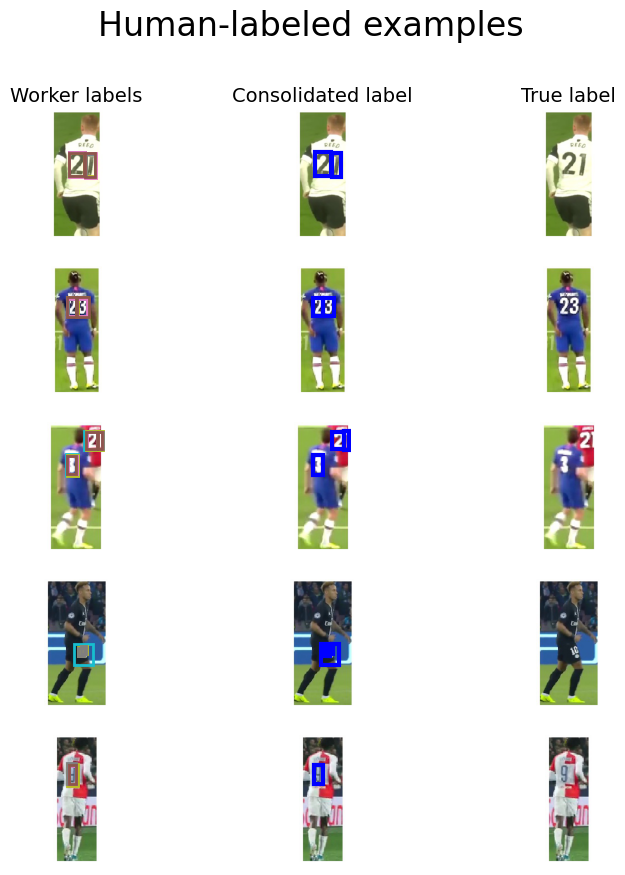

In [32]:
N_SHOW = 5

# Find human and auto-labeled images in the subset.
human_labeled_subset = [img for img in image_subset if img.human]
auto_labeled_subset = [img for img in image_subset if not img.human]

# Show examples of each
fig, axes = plt.subplots(N_SHOW, 3, figsize=(9, 2*N_SHOW),
                         facecolor='white', dpi=100)
fig.suptitle('Human-labeled examples', fontsize=24)
axes[0, 0].set_title('Worker labels', fontsize=14)
axes[0, 1].set_title('Consolidated label', fontsize=14)
axes[0, 2].set_title('True label', fontsize=14)
for row, img in enumerate(np.random.choice(human_labeled_subset, size=N_SHOW)):
    img.download(LOCAL_IMG_DIR)
    img.plot_worker_bbs(axes[row, 0])
    img.plot_consolidated_bbs(axes[row, 1])
    img.plot_gt_bbs(axes[row, 2])

if auto_labeled_subset:
    fig, axes = plt.subplots(N_SHOW, 2, figsize=(6, 2*N_SHOW),
                             facecolor='white', dpi=100)
    fig.suptitle('Auto-labeled examples', fontsize=24)
    axes[0, 0].set_title('Auto-label', fontsize=14)
    axes[0, 1].set_title('True label', fontsize=14)
    for row, img in enumerate(np.random.choice(auto_labeled_subset, size=N_SHOW)):
        img.download(LOCAL_IMG_DIR)
        img.plot_consolidated_bbs(axes[row, 0])
        img.plot_gt_bbs(axes[row, 1])
else:
    print("No images were auto-labeled.")